# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [108]:
INPUT_VARIABLE = 1

TRIAL_TIME_STAMP_DURATION = 1000*10

In [9]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s to 10cm/s"}

In [10]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 5cm/s", 1: "5cm/s to 10cm/s", 2: "10cm/s+"}

In [11]:
NUM_LINES = 3

In [12]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [13]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [14]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [15]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [16]:

ALL_SESSION_DIR = list(set(['/scratch/back_up/reward_competition_extention/data/omission/2022_12_02/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_15/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_14/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_03/20221203_154800_omission_and_competition_subject_6_4_and_6_1.rec',    '/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec'
                   ]))

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [17]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

### Getting the subject IDs from the file name

In [18]:
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/melted_trials_and_video.pkl")


In [19]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [20]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [21]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [22]:
all_trials_df["recording_dir"].unique()

array(['subj6_1_and_6_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [23]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [24]:
all_trials_df["all_subjects"].head()

0    [6.3]
1    [6.3]
2    [6.3]
3    [6.3]
4    [6.3]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [25]:
all_trials_df["subject_info"].head()

0    6_1_top_1_base_2_vs_6_3
1    6_1_top_1_base_2_vs_6_3
2    6_1_top_1_base_2_vs_6_3
3    6_1_top_1_base_2_vs_6_3
4    6_1_top_1_base_2_vs_6_3
Name: subject_info, dtype: object

In [26]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [27]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [28]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [29]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [30]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [31]:
competition_closeness_map

{'Subj 1 Only': 'non_comp',
 'Subj 2 Only': 'non_comp',
 'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 2 then Subj 1': 'comp',
 'Close Call': 'comp',
 nan: nan}

In [32]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [33]:
all_trials_df["competition_closeness"]

0      non_comp
1      non_comp
2      non_comp
3      non_comp
4      non_comp
         ...   
551         NaN
552         NaN
553         NaN
554         NaN
555         NaN
Name: competition_closeness, Length: 556, dtype: object

In [34]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [35]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,68781880.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,65588836.0,20230621_111240_standard_comp_to_omission_D5_s...,65550,1.0,1-4_t3b3L_box1,...,"[(65588836.0, 65608836.0), (65608836.0, 656288...","[(

In [36]:
all_trials_df["recording_dir"].unique()

array(['subj6_1_and_6_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

In [37]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in ALL_SESSION_DIR:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except Exception as e: 
            print(e)



20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
stream_id trodes is not in ['ECU']
stream_id trodes is not in ['ECU']
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
stream_id trodes is not in ['ECU']
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged
stream_id trodes is not in ['ECU']
20221215_145401_comp_amd_om_6_1_top_4_base_3
stream_id trodes is not in ['ECU']
20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
stream_id trodes is not in ['ECU']
stream_id trodes is not in ['ECU']
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
stream_id trodes is not in ['ECU']
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
20230618_100636_standard_comp_to_omission_D

- Filtering for all trials that have labels

In [38]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [39]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [40]:
all_trials_df["trial_outcome"].unique()

array(['win', 'lose', 'rewarded', 'omission'], dtype=object)

In [41]:
all_trials_df["trial_or_baseline"].unique()

array(['baseline', 'trial'], dtype=object)

In [42]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged', '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [43]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


## Power Calculation

In [44]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",baseline,"[2.036892327741516, 2.241836602029708, 2.57597...","[2.3533739428089473, 1.434358857024035, 3.0417...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]"
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,"[(27998597.0, 28018597.0), (28018597.0, 280385...","[(27798597.0, 27818597.0), (27818597.0, 278385...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(1389929.0, 1390929.0), (1390929.0, 1391929.0...",trial,"[0.7121153530651193, 0.6970557589759765, 0.724...","[0.9495329201051134, 3.0316038473645275, 1.981...","[(1399929.0, 1400929.0), (1400929.0, 1401929.0...","[(27998597.0, 28018597.0), (28018597.0, 280385...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",baseline,"[2.9530693043854934, 2.5889456564677213, 2.295...","[0.9727462488501508, 0.14160626330067091, 0.15...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[0, 0, 0, 0, 0, 2, 1, 1, 0, 0]"
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,"[(29598593.0, 29618593.0), (29618593.0, 296385...","[(29398593.0, 29418593.0), (29418593.0, 294385...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(1469929.0, 1470929.0), (1470929.0, 1471929.0...",trial,"[1.1091618874765725, 1.2067853545334786, 1.308...","[1.0503547684805281, 0.8329540254506201, 1.119...","[(1479929.0, 1480929.0), (1480929.0, 1481929.0...","[(29598593.0, 29618593.0), (29618593.0, 296385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,"[(31398591.0, 31418591.0), (31418591.0, 314385...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[(1569929.0, 1570929.0), (1570929.0, 1571929.0...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...",baseline,"[5.081365648592532, 4.988102332136219, 4.87467...","[3.3220810860024765, 0.6014839466006836, 0.252...","[(1559929.0, 1560929.0), (1560929.0, 1561929.0...","[(31198591.0, 31218591.0), (31218591.0, 312385...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Adding all the brain region to ch information

In [45]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [46]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

- Creating a new row for each brain region

In [47]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [48]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [49]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [50]:
melted_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,1,6.1,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21.0
1,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,1,6.1,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21.0
2,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,1,6.1,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21.0
3,32550496.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,29598593.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,...,1,6.1,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21.0
4,34350494.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,31398591.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,...,1,6.1,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21.0


In [51]:
melted_channel_map_and_all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
2775,68781880.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,65588836.0,20230621_111240_standard_comp_to_omission_D5_s...,65550,1.0,1-4_t3b3L_box1,...,2,1.4,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
2776,70681909.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,67488865.0,20230621_111240_standard_comp_to_omission_D5_s...,67447,1.0,1-4_t3b3L_box1,...,2,1.4,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
2777,70681909.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,67488865.0,20230621_111240_standard_comp_to_omission_D5_s...,67447,1.0,1-4_t3b3L_box1,...,2,1.4,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
2778,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,2,1.4,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,2,1.4,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0


- Getting the traces for each trial for each brain region

In [52]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [53]:
melted_channel_map_and_all_trials_df["chunked_lfp_index"].iloc[0]

[(1389929.0, 1390929.0),
 (1390929.0, 1391929.0),
 (1391929.0, 1392929.0),
 (1392929.0, 1393929.0),
 (1393929.0, 1394929.0),
 (1394929.0, 1395929.0),
 (1395929.0, 1396929.0),
 (1396929.0, 1397929.0),
 (1397929.0, 1398929.0),
 (1398929.0, 1399929.0)]

In [54]:
melted_channel_map_and_all_trials_df["binned_current_thorax_velocity"].iloc[0]

[0, 0, 0, 0, 2, 0, 1, 1, 0, 0]

In [55]:
melted_channel_map_and_all_trials_df["chunked_current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
[x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=chunk_index[0], end_frame=chunk_index[1]).T[0] for chunk_index in x["chunked_lfp_index"]], axis=1)

In [56]:
len(melted_channel_map_and_all_trials_df["chunked_current_trace"].iloc[0])

10

In [57]:
melted_channel_map_and_all_trials_df["chunked_current_trace"]

0       [[-0.37521854, -0.46455628, -0.9559139, -1.541...
1       [[0.23004471, 0.020100994, -0.055836093, -0.16...
2       [[1.4763063, 1.4227036, 1.3534669, 1.1591573, ...
3       [[0.8085066, 0.6476987, 0.4846573, 0.5471937, ...
4       [[0.020100994, 0.62536424, 0.38638577, 0.10943...
                              ...                        
2775    [[-0.9353915, -1.0308397, -0.97357076, -0.5408...
2776    [[1.6671604, 1.5685307, 1.3839977, 1.823059, 2...
2777    [[0.3404316, 0.35315803, 0.21953066, -0.283162...
2778    [[-0.62359434, -0.009544811, 0.52496463, 0.668...
2779    [[0.06681368, 0.4326981, 0.658592, 0.64586556,...
Name: chunked_current_trace, Length: 2780, dtype: object

In [58]:
melted_channel_map_and_all_trials_df["chunk_id"] = [list(range(0,10))] * len(melted_channel_map_and_all_trials_df)

In [59]:
exploded_channel_map_and_all_trials_df = melted_channel_map_and_all_trials_df.explode(["current_chunked_thorax_velocity", "chunked_current_trace", "binned_current_thorax_velocity", "chunked_lfp_index", "chunked_ephys_timestamp", "chunk_id"])

In [60]:
exploded_channel_map_and_all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel,chunked_current_trace,chunk_id
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-0.37521854, -0.46455628, -0.9559139, -1.5410...",0
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-1.3266655, -1.7532533, -2.4478543, -3.017382...",1
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.06030298, -0.7258692, -1.1435232, -0.640998...",2
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[2.5126243, 2.481356, 2.2982135, 2.0346673, 1....",3
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,NaN,15,14,13,31,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.3997864, -0.09157119, -0.082637414, 0.25907...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[0.18453301, -0.31816038, -0.88130426, -1.2599...",5
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.31179717, -0.49951178, -0.48042217, -0.318...",6
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.9862972, -1.027658, -0.9926604, -0.9322099...",7
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,NaN,15,14,13,12,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[1.8612382, 1.9789575, 2.3893845, 2.5834622, 2...",8


In [61]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: len(x))


In [62]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"].unique()

array([1000, 1001])

In [63]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: x[:RESAMPLE_RATE])

In [64]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"]

0       [-0.37521854, -0.46455628, -0.9559139, -1.5410...
0       [-1.3266655, -1.7532533, -2.4478543, -3.017382...
0       [0.06030298, -0.7258692, -1.1435232, -0.640998...
0       [2.5126243, 2.481356, 2.2982135, 2.0346673, 1....
0       [0.3997864, -0.09157119, -0.082637414, 0.25907...
                              ...                        
2779    [0.18453301, -0.31816038, -0.88130426, -1.2599...
2779    [-0.31179717, -0.49951178, -0.48042217, -0.318...
2779    [-0.9862972, -1.027658, -0.9926604, -0.9322099...
2779    [1.8612382, 1.9789575, 2.3893845, 2.5834622, 2...
2779    [1.533533, 1.5621674, 1.5653491, 1.5526227, 1....
Name: chunked_current_trace, Length: 27800, dtype: object

- Calcuating the power at each frequency band

In [109]:
exploded_channel_map_and_all_trials_df["multitaper"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: Multitaper(time_series=x,                                                                                        sampling_frequency=RESAMPLE_RATE))

In [110]:
exploded_channel_map_and_all_trials_df["connectivity"] = exploded_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [111]:
exploded_channel_map_and_all_trials_df["frequencies"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [112]:
exploded_channel_map_and_all_trials_df["power"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [113]:
exploded_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,all_ch_lfp,brain_region,channel,chunked_current_trace,chunk_id,len_chunked_current_trace,multitaper,connectivity,frequencies,power
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-0.37521854, -0.46455628, -0.9559139, -1.5410...",0,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.013959614727656923, 0.027300432690108158, 0..."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-1.3266655, -1.7532533, -2.4478543, -3.017382...",1,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.044412349767875496, 0.03103414013080552, 0...."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.06030298, -0.7258692, -1.1435232, -0.640998...",2,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02096695540904013, 0.022014879021411908, 0...."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[2.5126243, 2.481356, 2.2982135, 2.0346673, 1....",3,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.15970044442295084, 0.1909207043404699, 0.15..."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.3997864, -0.09157119, -0.082637414, 0.25907...",4,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.024495444709458945, 0.02160711385191206, 0...."


In [114]:
exploded_channel_map_and_all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,all_ch_lfp,brain_region,channel,chunked_current_trace,chunk_id,len_chunked_current_trace,multitaper,connectivity,frequencies,power
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[0.18453301, -0.31816038, -0.88130426, -1.2599...",5,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.005819180769489445, 0.00610071779626623, 0...."
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.31179717, -0.49951178, -0.48042217, -0.318...",6,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.016223265480284414, 0.015883819694659986, 0..."
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[-0.9862972, -1.027658, -0.9926604, -0.9322099...",7,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.07977984053193657, 0.10953939231332364, 0.1..."
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[1.8612382, 1.9789575, 2.3893845, 2.5834622, 2...",8,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.016028934050243356, 0.014327537906036426, 0..."
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28,"[1.533533, 1.5621674, 1.5653491, 1.5526227, 1....",9,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.031235121983499342, 0.04508811637509299, 0...."


# Plotting by velocity

- Grouping all the rows(1s segment of trials) that share the same brain region, whether its before or after the tone, and velocity grouping

In [115]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

- Calculating the mean and sem of the LFP power

In [116]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [117]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [118]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [119]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

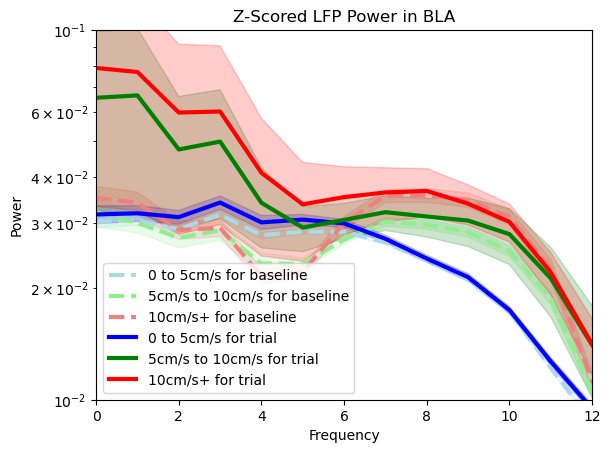

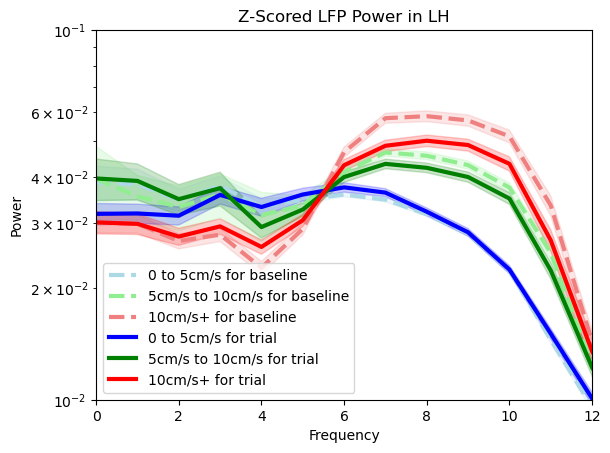

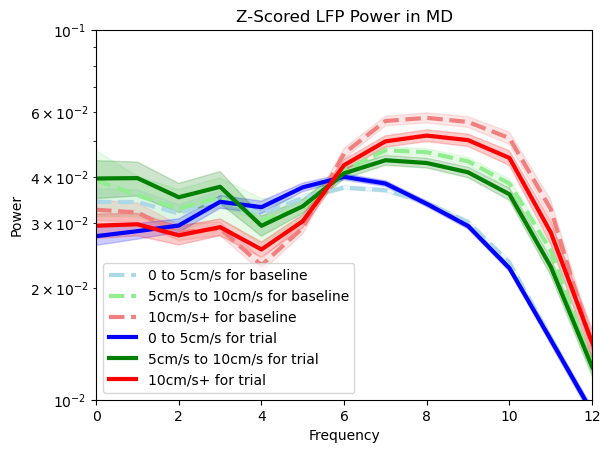

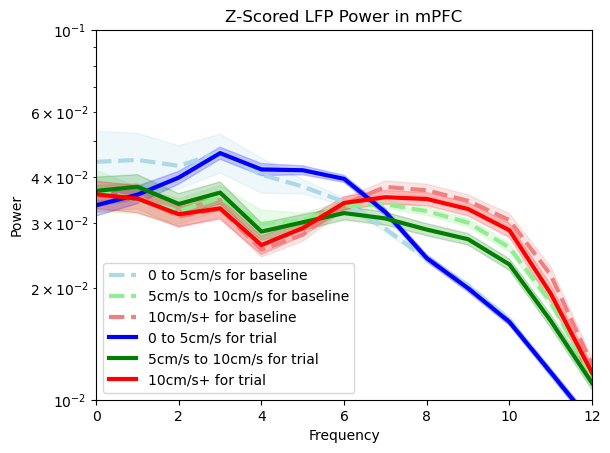

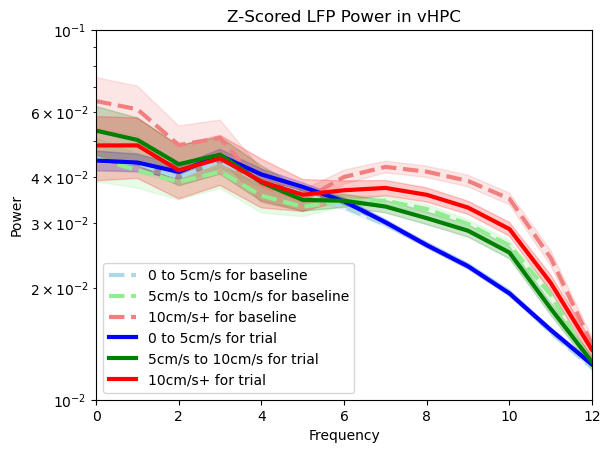

In [120]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.legend(loc="lower left")
    
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


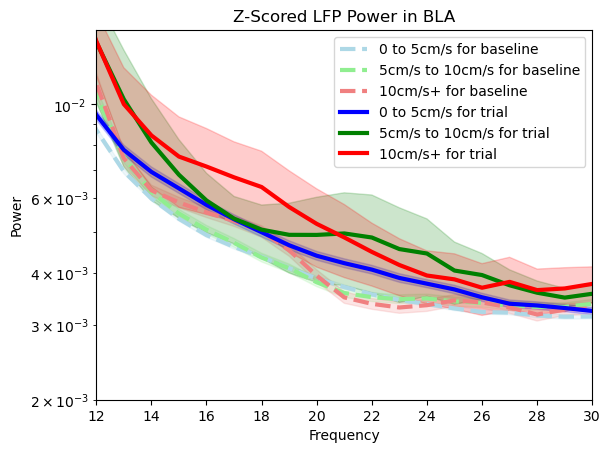

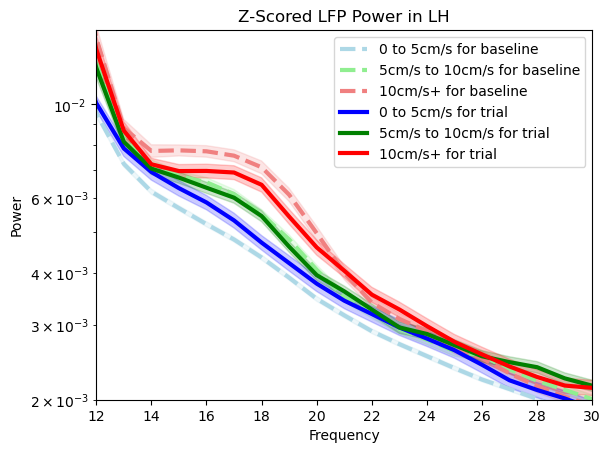

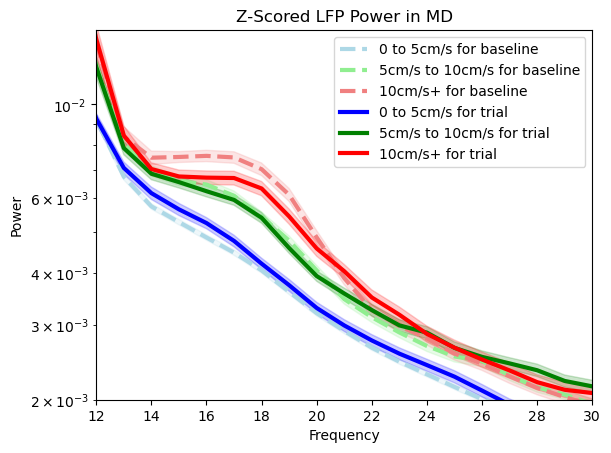

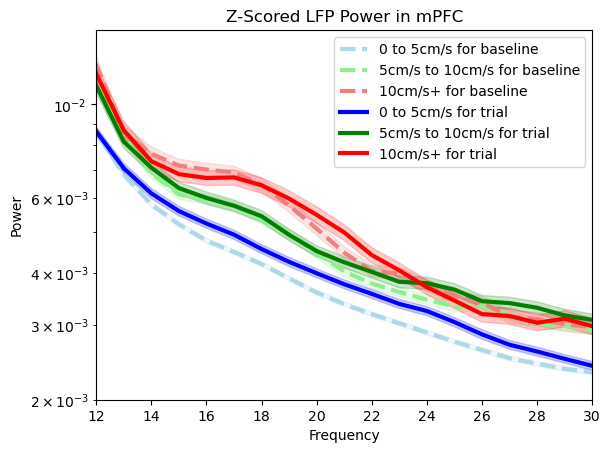

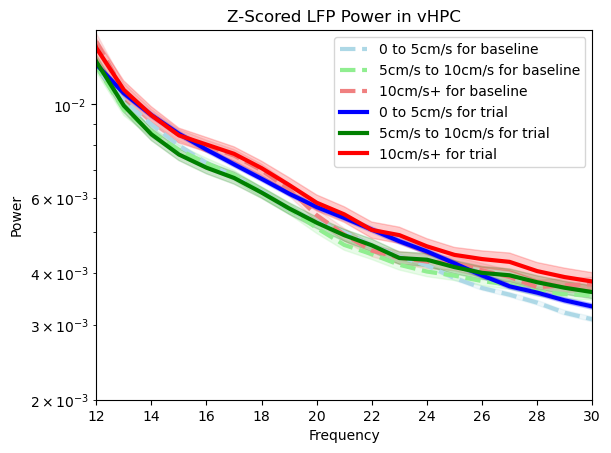

In [121]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


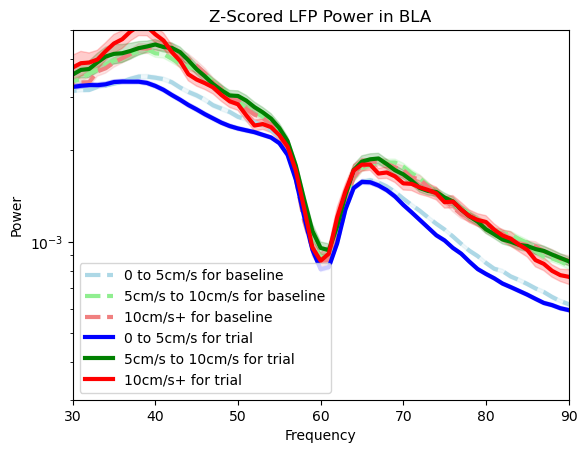

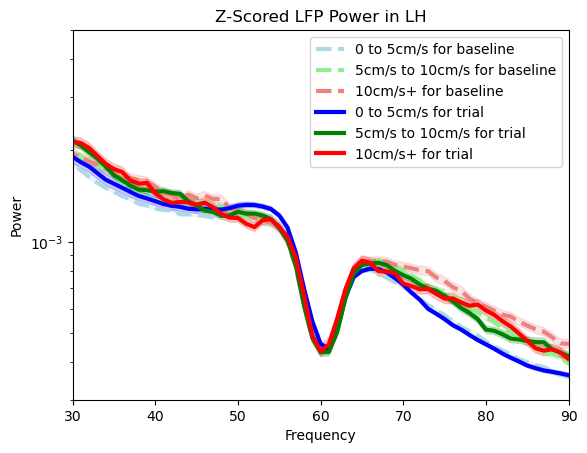

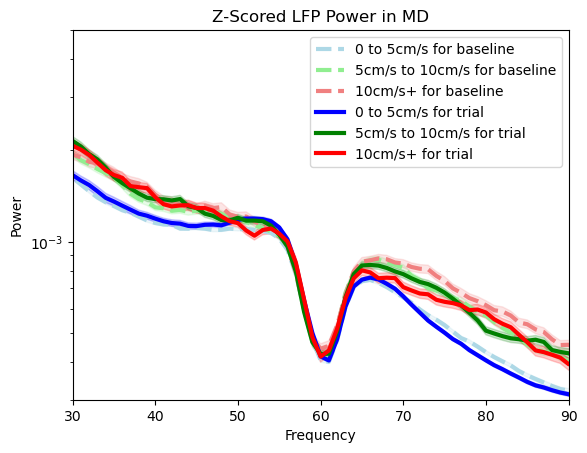

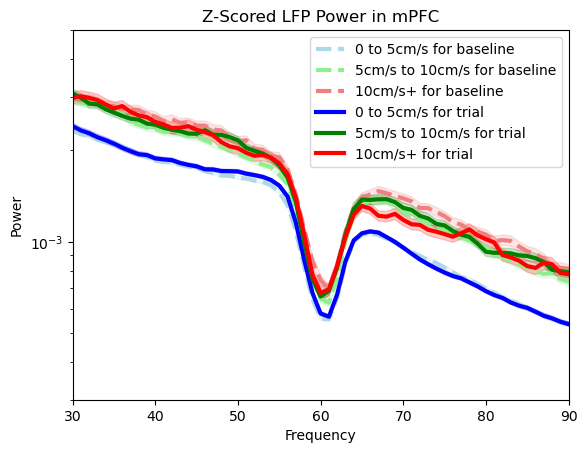

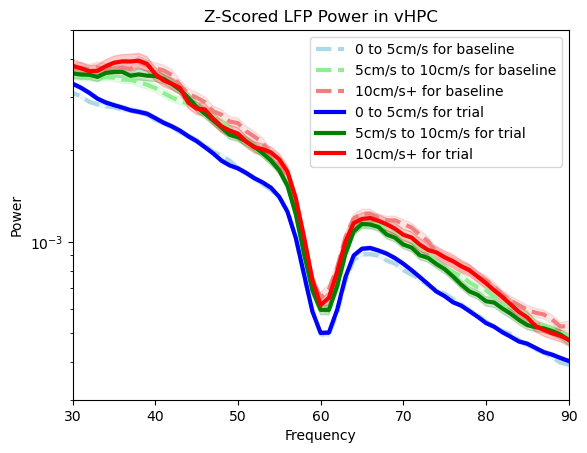

In [122]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    # plt.ylim(0, 0.005)
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


## Plotting all the lower velocities together

In [123]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] == 0]

In [124]:
speed_filtered_all_trials_df.shape

(21285, 79)

In [125]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [126]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [127]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [128]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [129]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [130]:
grouped_all_trials_df["trial_outcome"].unique()

array(['lose', 'omission', 'rewarded', 'win'], dtype=object)

# Drawing plots all together

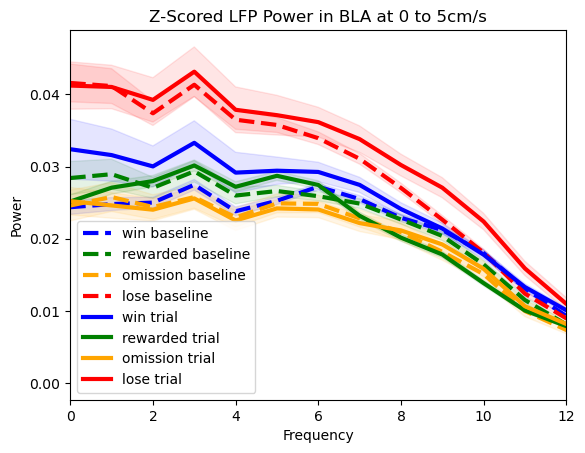

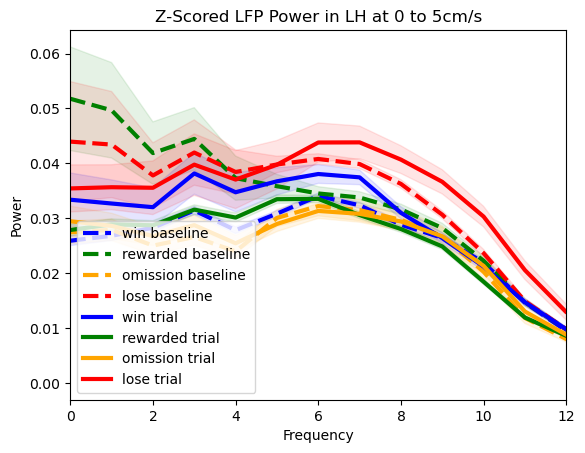

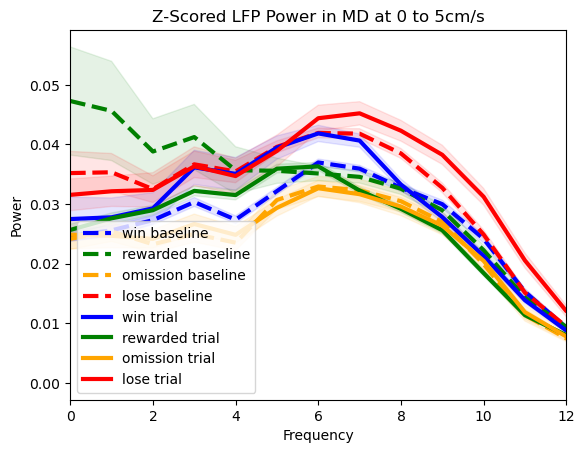

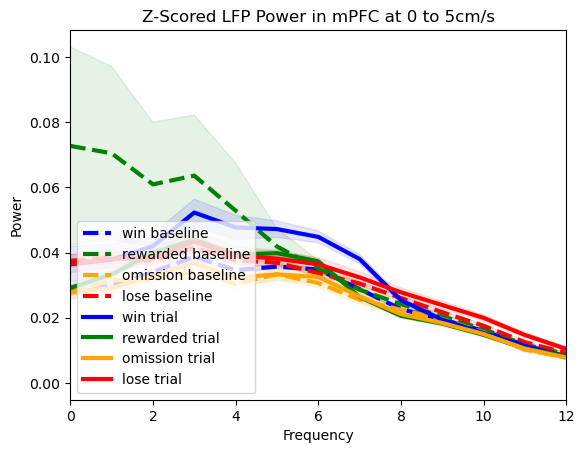

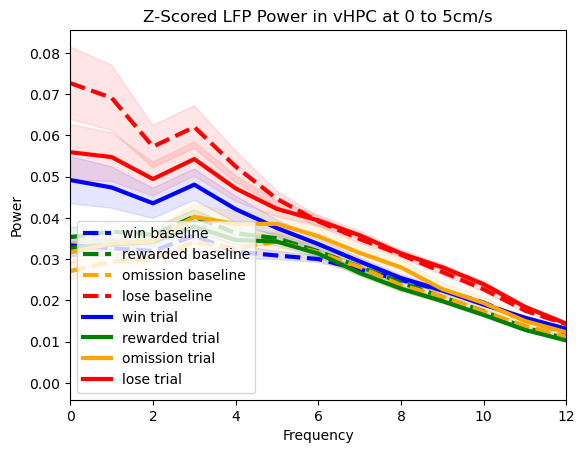

In [131]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    # plt.ylim(0.01, 0.06)

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="lower left")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

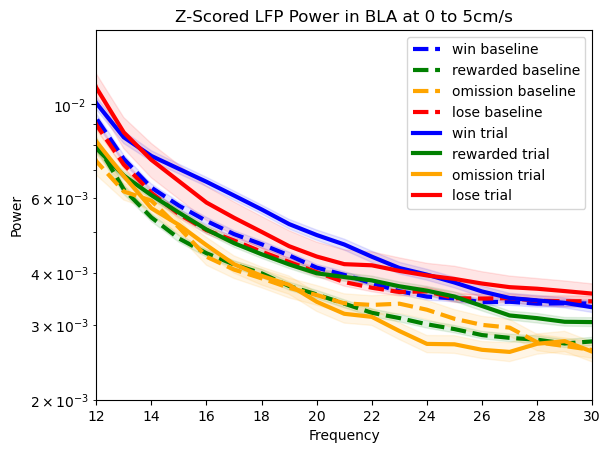

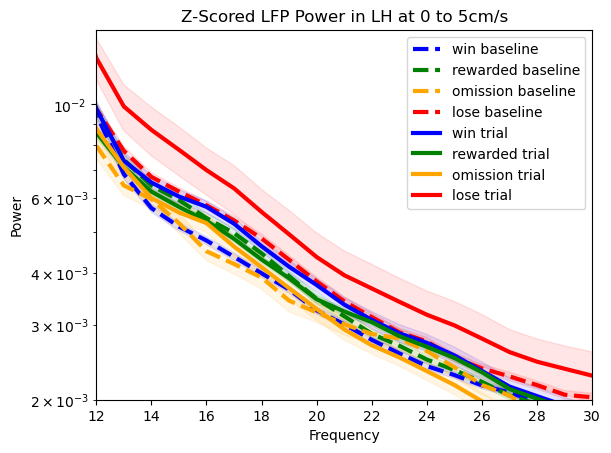

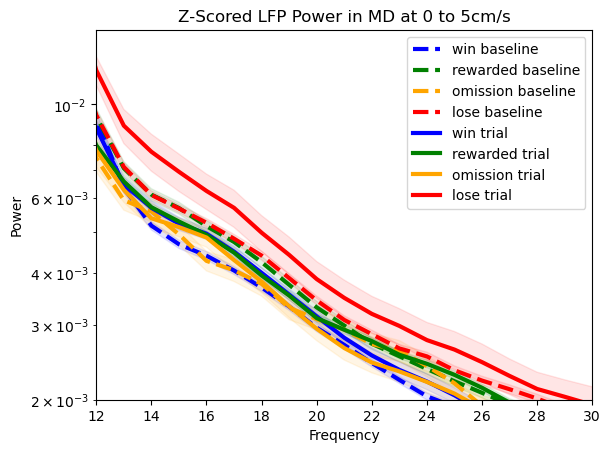

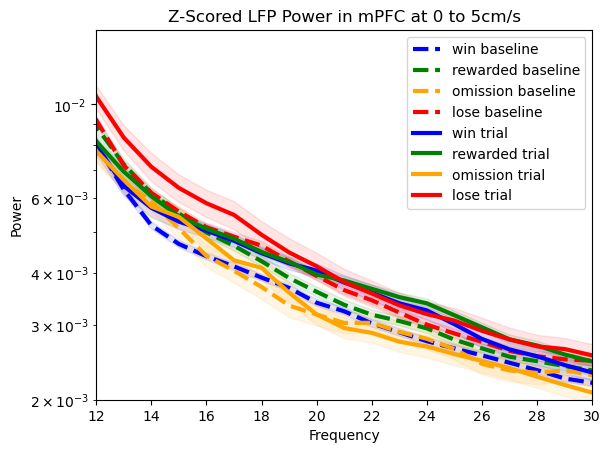

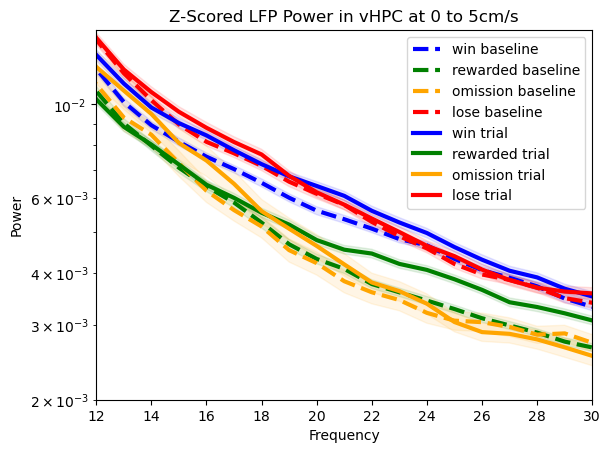

In [132]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="upper right")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

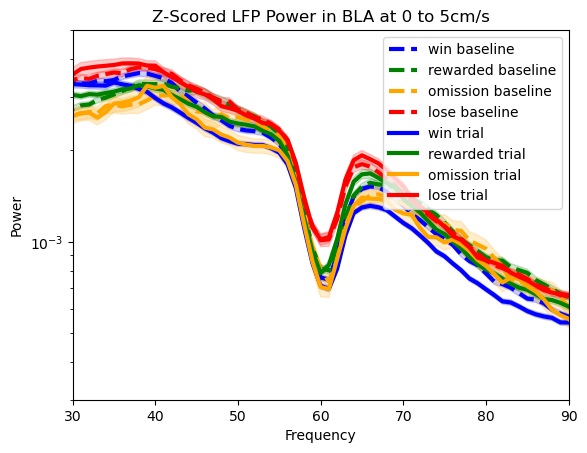

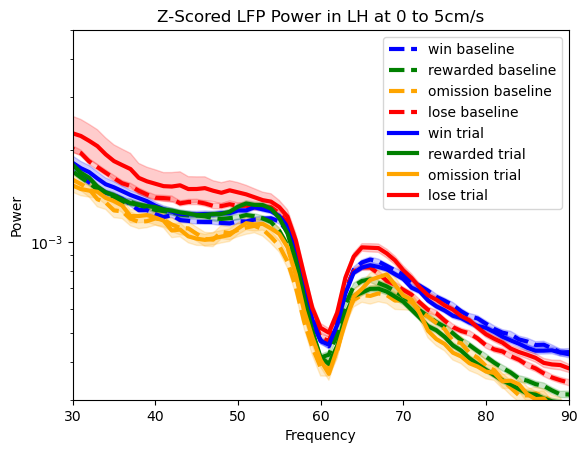

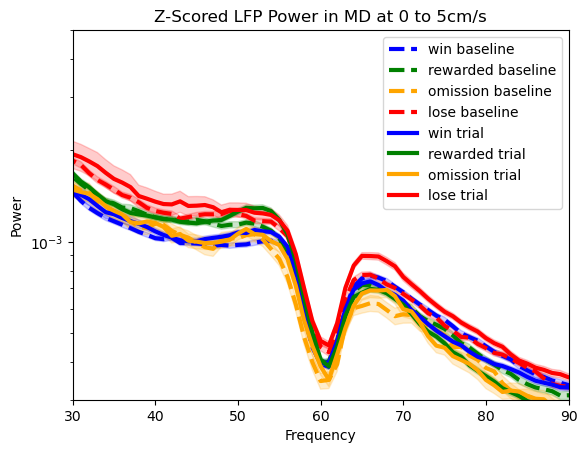

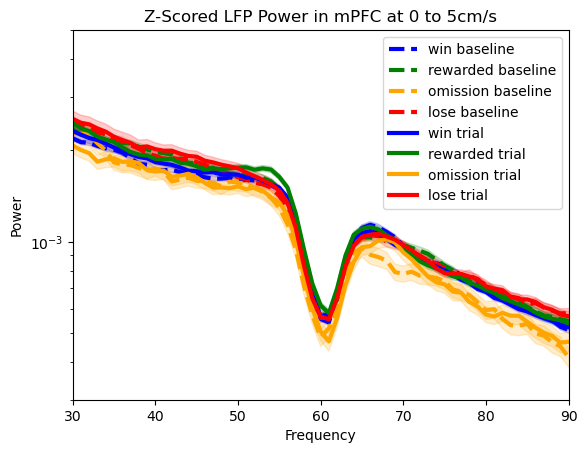

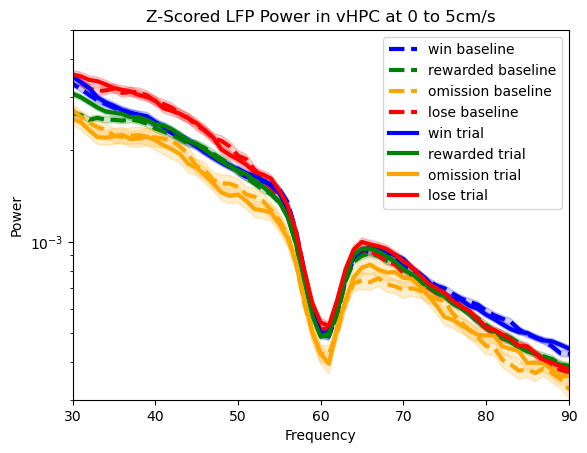

In [133]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="upper right")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

# Saving to pickle with all unnecssary columns removed

In [134]:
exploded_channel_map_and_all_trials_df.columns

Index(['time', 'state', 'recording_dir', 'recording_file', 'din',
       'time_stamp_index', 'video_file', 'video_frame', 'video_number',
       'subject_info', 'condition', 'competition_closeness', 'Unnamed: 13',
       'resampled_index', 'all_subjects', 'current_subject', 'trial_outcome',
       'video_name', 'file_path', 'start_frame', 'stop_frame',
       'individual_subj', 'all_subj', 'recording_name', 'all_sleap_data',
       'locations', 'track_names', 'subject_to_index', 'subject_id',
       'subject_locations', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'rescaled_locations',
       'box_bottom_left', 'reward_port', 'box_top_left', 'box_top_right',
       'box_bottom_right', 'all_thorax_locations', 'all_thorax_velocity',
       'trial_thorax_velocity', 'baseline_thorax_velocity',
       'trial_chunked_thorax_velocity', 'baseline_chunked_thorax_velocity

In [135]:
exploded_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,all_ch_lfp,brain_region,channel,chunked_current_trace,chunk_id,len_chunked_current_trace,multitaper,connectivity,frequencies,power
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-0.37521854, -0.46455628, -0.9559139, -1.5410...",0,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.013959614727656923, 0.027300432690108158, 0..."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[-1.3266655, -1.7532533, -2.4478543, -3.017382...",1,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.044412349767875496, 0.03103414013080552, 0...."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.06030298, -0.7258692, -1.1435232, -0.640998...",2,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02096695540904013, 0.022014879021411908, 0...."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[2.5126243, 2.481356, 2.2982135, 2.0346673, 1....",3,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.15970044442295084, 0.1909207043404699, 0.15..."
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,21,"[0.3997864, -0.09157119, -0.082637414, 0.25907...",4,1000,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.024495444709458945, 0.02160711385191206, 0...."


In [138]:
output_columns = ['time', 'state', 'recording_dir', 'recording_file', 'din', 'time_stamp_index', 'video_file', 'video_frame', 'video_number', 
'subject_info', 'condition', 'competition_closeness',
'resampled_index', 'all_subjects', 'current_subject', 'trial_outcome',
'video_name', 'file_path', 'start_frame', 'stop_frame',
'individual_subj', 'all_subj', 'recording_name',
'subject_id',
'brain_region', 'channel', 'chunked_current_trace', 'chunk_id', 'frequencies', 'power', "binned_current_thorax_velocity", "trial_or_baseline"]

In [139]:
exploded_channel_map_and_all_trials_df[output_columns].to_pickle("./proc/rce_1_sec_interval_lfp_power_spectra_and_velocity.pkl")

In [140]:
exploded_channel_map_and_all_trials_df[output_columns]

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,recording_name,subject_id,brain_region,channel,chunked_current_trace,chunk_id,frequencies,power,binned_current_thorax_velocity,trial_or_baseline
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,20221214_125409_om_and_comp_6_1_and_6_3,6.1,spike_interface_mPFC,21,"[-0.37521854, -0.46455628, -0.9559139, -1.5410...",0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.013959614727656923, 0.027300432690108158, 0...",0,baseline
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,20221214_125409_om_and_comp_6_1_and_6_3,6.1,spike_interface_mPFC,21,"[-1.3266655, -1.7532533, -2.4478543, -3.017382...",1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.044412349767875496, 0.03103414013080552, 0....",0,baseline
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,20221214_125409_om_and_comp_6_1_and_6_3,6.1,spike_interface_mPFC,21,"[0.06030298, -0.7258692, -1.1435232, -0.640998...",2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02096695540904013, 0.022014879021411908, 0....",0,baseline
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,20221214_125409_om_and_comp_6_1_and_6_3,6.1,spike_interface_mPFC,21,"[2.5126243, 2.481356, 2.2982135, 2.0346673, 1....",3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.15970044442295084, 0.1909207043404699, 0.15...",0,baseline
0,30950500.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,27998597.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,...,20221214_125409_om_and_comp_6_1_and_6_3,6.1,spike_interface_mPFC,21,"[0.3997864, -0.09157119, -0.082637414, 0.25907...",4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.024495444709458945, 0.02160711385191206, 0....",2,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,spike_interface_MD,28,"[0.18453301, -0.31816038, -0.88130426, -1.2599...",5,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.005819180769489445, 0.00610071779626623, 0....",0,trial
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,spike_interface_MD,28,"[-0.31179717, -0.49951178, -0.48042217, -0.318...",6,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.016223265480284414, 0.015883819694659986, 0...",0,trial
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,68488874.0,20230621_111240_standard_comp_to_omission_D5_s...,68444,1.0,1-4_t3b3L_box1,...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,spike_interface_MD,28,"[-0.9862972, -1.027658, -0.9926604, -0.9322099...",7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.07977984053193657, 0.10953939231332364, 0.1...",0,trial
2779,71681918.0,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_co